In [5]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes
from pycocotools.coco import COCO
from os.path import abspath, expanduser
from typing import Dict, List, Union
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [6]:
!python --version

Python 3.8.5


In [178]:
class Compose(object):
    def __init__(self):
        self.transforms = [T.Resize(size=(400, 400)), T.ToTensor()]

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img = t(img)

        return img, bboxes

In [246]:
class WIDERFace(Dataset):
    BASE_FOLDER = "widerface"

    def __init__(self, root, split="train", transform=None):
        # check arguments
        self.root = os.path.join(root, self.BASE_FOLDER)
        self.transform = transform
        self.split = split
        self.img_info: List[Dict[str, Union[str, Dict[str, torch.Tensor]]]] = []

        if self.split in ("train", "val"):
            self.parse_train_val_annotations_file()
        else:
            self.parse_test_annotations_file()

    def __getitem__(self, index: int):
        img = Image.open(self.img_info[index]["img_path"]).convert("RGB")
        boxes = self.img_info[index]["annotations"]["bbox"]
        
        img_shape = np.array(img)
        img_h = img_shape.shape[0]
        img_w = img_shape.shape[1]
        boxes[:, 0] /= img_w
        boxes[:, 1] /= img_h
        boxes[:, 2] /= img_w
        boxes[:, 3] /= img_h
        
        if self.transform:
            img, boxes = self.transform(img, boxes)

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
            
        new_boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        label = {"boxes": new_boxes, 
                 "labels": torch.tensor([0 for i in range(new_boxes.size(0))], dtype=torch.int64)}
        return img, label

    def __len__(self):
        return len(self.img_info)

    def extra_repr(self):
        lines = ["Split: {split}"]
        return "\n".join(lines).format(**self.__dict__)

    def parse_train_val_annotations_file(self):
        filename = "wider_face_train_bbx_gt.txt" if self.split == "train" else "wider_face_val_bbx_gt.txt"
        filepath = os.path.join(self.root, "wider_face_split", filename)

        with open(filepath) as f:
            lines = f.readlines()
            file_name_line, num_boxes_line, box_annotation_line = True, False, False
            num_boxes, box_counter = 0, 0
            labels = []
            for line in lines:
                line = line.rstrip()
                if file_name_line:
                    img_path = os.path.join(self.root, "WIDER_" + self.split,
                                            "images", line)
                    if not os.path.isfile(img_path):
                        continue
                    img_path = abspath(expanduser(img_path))
                    file_name_line = False
                    num_boxes_line = True
                elif num_boxes_line:
                    num_boxes = int(line)
                    num_boxes_line = False
                    box_annotation_line = True
                elif box_annotation_line:
                    box_counter += 1
                    line_split = line.split(" ")
                    line_values = [int(x) for x in line_split]
                    labels.append(line_values)
                    if box_counter >= num_boxes:
                        box_annotation_line = False
                        file_name_line = True
                        labels_tensor = torch.tensor(labels)[:, 0:4].float()
                        self.img_info.append(
                            {
                                "img_path": img_path,
                                "annotations": {
                                    "bbox": labels_tensor
                                    # x, y, width, height
                                },
                            }
                        )
                        box_counter = 0
                        labels.clear()
                else:
                    raise RuntimeError(
                        f"Error parsing annotation file {filepath}")

In [247]:
transform = Compose()
train_data = WIDERFace(root="data/", split="train", transform=transform)
test_data = WIDERFace(root="data/", split="val", transform=transform)

In [248]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [249]:
batch_size = 1
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle=False, collate_fn=collate_fn)

In [250]:
images, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
images_test, targets_test = next(iter(test_loader))
images_test = list(image for image in images_test)
targets_test = [{k:v for k, v in t.items()} for t in targets_test]

In [252]:
targets_test[0]

{'boxes': tensor([[0.3369, 0.3112, 0.3408, 0.3171],
         [0.3232, 0.1858, 0.3262, 0.1903],
         [0.2441, 0.1858, 0.2471, 0.1917],
         [0.2158, 0.1888, 0.2197, 0.1962],
         [0.4170, 0.1711, 0.4199, 0.1770],
         [0.3838, 0.1165, 0.3867, 0.1224],
         [0.3643, 0.1755, 0.3672, 0.1814],
         [0.0879, 0.3319, 0.0938, 0.3392],
         [0.1250, 0.3496, 0.1299, 0.3614],
         [0.1660, 0.3392, 0.1709, 0.3481],
         [0.1113, 0.4204, 0.1162, 0.4307],
         [0.0791, 0.4484, 0.0879, 0.4617],
         [0.0430, 0.4469, 0.0527, 0.4587],
         [0.0068, 0.3894, 0.0127, 0.4012],
         [0.0303, 0.3407, 0.0352, 0.3496],
         [0.0254, 0.2832, 0.0312, 0.2950],
         [0.0645, 0.2891, 0.0684, 0.2979],
         [0.0723, 0.2581, 0.0771, 0.2655],
         [0.1104, 0.2478, 0.1143, 0.2552],
         [0.1260, 0.2434, 0.1299, 0.2507],
         [0.1543, 0.2389, 0.1582, 0.2448],
         [0.1699, 0.2301, 0.1748, 0.2389],
         [0.1924, 0.2345, 0.1963, 0.2404],
  

In [226]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = FT.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

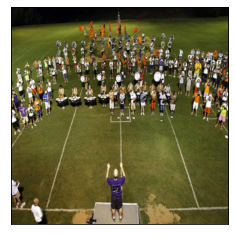

In [244]:
show(draw_bounding_boxes((images_test[0]*255).type(torch.uint8), targets_test[0]["boxes"]*400))

In [234]:
for i, (x,y) in enumerate(test_loader):
    boxes = y[0]["boxes"]
#     show(draw_bounding_boxes((x[0]*255).type(torch.uint8), (boxes*400)))
    print(boxes[:,0] == 0.732421875)
    if boxes[:,0] == 0.732421875:
        print("what")
    break

tensor([False])


In [76]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
preds = [dict(boxes=torch.tensor([[258.0, 41.0, 606.0, 285.0],[2.2, 1.2, 2.2, 1.2]]),scores=torch.tensor([0.536, 0.6]),labels=torch.tensor([0, 0]),)]
target = [dict(boxes=torch.tensor([[214.0, 41.0, 562.0, 285.0], [2.3, 1.3, 2.3, 1.3]]),labels=torch.tensor([0, 0]),)]
metric = MeanAveragePrecision()
metric.update(preds, target)
maps = metric.compute()